<img src="https://www.rp.edu.sg/images/default-source/default-album/rp-logo.png" width="200" alt="Republic Polytechnic"/>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/koayst-rplesson/SDGAI_LLMforGenAIApp_Labs/blob/main/L13/L13_Challenge_Answer.ipynb)

# Setup and Installation

You can run this Jupyter notebook either on your local machine or run it at Google Colab.

* For local machine, it is recommended to install Anaconda and create a new development environment called `c3669c`.
* Pip/Conda install the libraries stated below when necessary.
---

# <font color='red'>ATTENTION</font>

## Google Colab
- If you are running this code in Google Colab, **DO NOT** store the API Key in a text file and load the key later from Google Drive. This is insecure and will expose the key.
- **DO NOT** hard code the API Key directly in the Python code, even though it might seem convenient for quick development.
- You need to enter the API key at python code `getpass.getpass()` when ask.

## Local Environment/Laptop
- If you are running this code locally in your laptop, you can create a env.txt and store the API key there.
- Make sure env.txt is in the same directory of this Jupyter notebook.
- You need to install `python-dotenv` and run the Python code to load in the API key.

---
```
%pip install python-dotenv

from dotenv import load_dotenv

load_dotenv('env.tx')
openai_api_key = os.getenv('OPENAI_API_KEY')
```
---

## GitHub/GitLab
- **DO NOT** `commit` or `push` API Key to services like GitHub or GitLab.

# Lesson 13 Challenge

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain
%pip install --quiet -U langgraph
%pip install --quiet -U langchain-openai
%pip install --quiet -U langchain-community
%pip isntall --quiet -U tavily-python
%pip install --quiet -U wikipedia

In [ ]:
# langchain              0.3.11
# langgraph              0.2.59
# langchain-core         0.3.24
# langchain-openai       0.2.12
# langchain-community    0.3.12
# openai                 1.57.2
# pydantic               2.10.3
# tavily-python          0.5.0
# wikipedia              1.4.0     

In [1]:
import getpass
import os

# setup the OpenAI API Key

# get OpenAI API key ready and enter it when ask
os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


In [2]:
# Goto https://tavily.com/ and sign up to get an API key

# get Tavily Search API key ready and enter it when ask
os.environ["TAVILY_API_KEY"] = getpass.getpass()

 ········


---

## Challenge
We will be using Wikipedia and a Google search services to gather contexts to answer a question directed to the LLM. You just need to complete the code and build the graph. Run test on it to ensure that it is working. Feel free to further improve it.

**NOTE**</br>
Make sure you have signed up at [Tavily](https://tavily.com/) and get an API key before continuing.

In [3]:
from langchain_openai import ChatOpenAI

from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph, START, END

from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

from IPython.display import Image, display

In [4]:
model = ChatOpenAI(
    model = 'gpt-4o-mini'
)

In [5]:
# complete the code
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list[AnyMessage], add_messages]

In [6]:
# define search_web node

def search_web(state):
    """ Retrieve docs from web search """
    tavily_search = TavilySearchResults(max_results=3)    # return three search result
    search_docs = tavily_search.invoke(state['question'])

    # format the search result
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in search_docs            
        ]
    )

    return {"context" : [formatted_search_docs]}

In [7]:
def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """
    # Search
    search_docs = WikipediaLoader(
        query=state['question'], 
        load_max_docs=2).load()

    # format the search result
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [8]:
# define a answer generation node

def generate_answer(state):
    """ Node to generate answer """

    # get context and question from state
    context = state['context']
    question = state['question']

    answer_template = """Answer the question: {question} using this context: {context}"""
    answer_instructions = answer_template.format(question = question, context = context)

    # Now get the model (LLM) to answer
    answer = model.invoke(
        [SystemMessage(content = answer_instructions)] +
        [HumanMessage(content = "Please answer the question and indicate the source of truth.")]
    )

    return {"answer" : answer}  

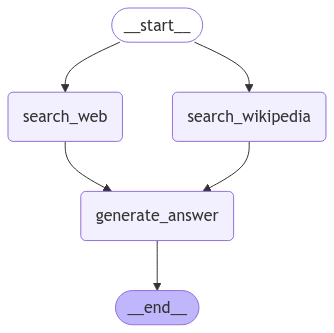

In [9]:
# Build the graph

builder = StateGraph(State)

# setup the nodes
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# connect the nodes
builder.add_edge(START, "search_web")
builder.add_edge(START, "search_wikipedia")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)

#compile the graph as assistant
assistant = builder.compile()

# display the graph
display(Image(assistant.get_graph().draw_mermaid_png()))

In [10]:
result = assistant.invoke({"question": "How were Nvidia's Q2 2024 earnings"})

print(result['answer'].content)

Nvidia reported strong Q2 2024 earnings, achieving $13 billion in revenue, which surpassed previous records due to high demand for its data center products and the launch of its Hopper architecture. The company has shown significant growth in its data center segment, driven by the rise of large language models in AI, and anticipates continued growth moving into the next quarter, with expectations to reach $16 billion in revenue in Q3.

Source: [AnandTech](https://www.anandtech.com/show/20024/nvidia-reports-q2-fy2024-earnings-13b-revnues-blows-past-records-on-absurd-data-center-demand)


In [ ]:
---